In [ ]:
import torch 
import sys
import os

current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
parent_dir = os.path.abspath(os.path.join(current_dir, '../../examples/dalitz_analysis'))
sys.path.append(parent_dir)


from gen_3body_phase_space import Gen3BodyPhaseSpace

m_omega = 782.660
m_etaP = 957.780
m_eta = 547.862
m_p = 139.57061     
m_pi0 = 134.9768

mass_dict = {
    'eta': [m_eta,m_p,m_p,m_pi0],
    'etaP': [m_etaP,m_p,m_p,m_eta],
    'omega': [m_omega,m_p,m_p,m_pi0]
}

pp = Gen3BodyPhaseSpace(mass_dict,"pp_mask")
pp.create_phase_space_mask()

In [2]:
from dalitz_theory import DalitzTheory
from omegaconf import OmegaConf

cfg = {
    'id': 'DalitzTheory',
    'grid_size': 100,
    'mask_dir': "pp_mask",
    'eps': 1e-11,
    'average': True,
}
cfg = OmegaConf.create(cfg)

theory = DalitzTheory(cfg,devices="mps")

true_params = torch.as_tensor(
    [[-1.144,0.219,0.0,0.086,0.0,0.115],[-0.056,-0.049,0.0,-0.063,0.0,0.0],[0.133,0.037,0.0,0.0,0.0,0.0]],
    device='mps',dtype=torch.float32)[None,:]

print(f"true-params: {true_params.size()}")

out = theory.forward(true_params)



true-params: torch.Size([1, 3, 6])


torch.Size([1, 3, 100, 100])


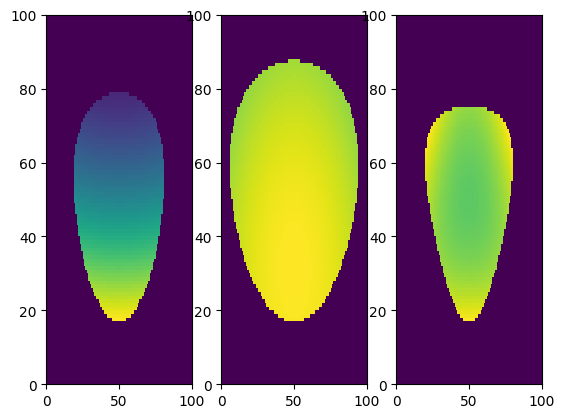

In [10]:
import matplotlib.pyplot as plt

print(out[0].size())

a = out[0].detach().cpu().numpy()[0]

fig,ax = plt.subplots(1,3)

ax[0].pcolormesh(a[0].T)
ax[1].pcolormesh(a[1].T)
ax[2].pcolormesh(a[2].T)

plt.show()




In [11]:
from quantom_ips.envs.samplers.loits_2d import LOInverseTransformSampler2D

cfg = {
    "average": True,
    "a_min": 0.0,
    "a_max": 1.0,
    "n_interpolations_x": 10,
    "n_interpolations_y": 10,
    "use_threading": False,
    "vmap_randomness": "different",
    "log_space": False,
    "static_weight_tensor": False,
    "id": "LOInverseTransformSampler2D"
}

cfg = OmegaConf.create(cfg)

sampler = LOInverseTransformSampler2D(config=cfg,devices="mps")
events = sampler.forward(out[0],out[1],100000,None).detach().cpu().numpy()[0]


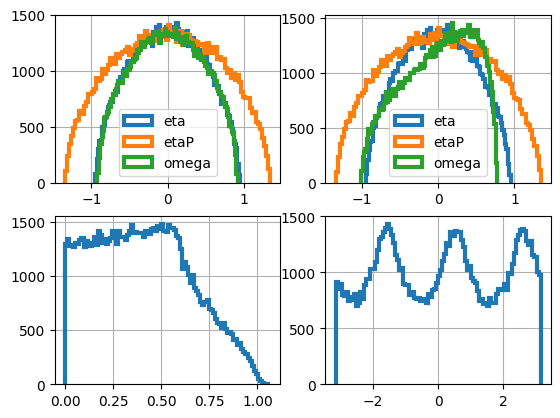

In [21]:
import numpy as np
from matplotlib.colors import LogNorm

x_omega = events[2][:,0]
y_omega = events[2][:,1]

Z = x_omega**2 + y_omega**2
Phi = np.atan2(y_omega,x_omega)

fig,ax = plt.subplots(2,2)

ax[0,0].hist(events[0][:,0],100,label='eta',histtype='step',linewidth=3.0)
ax[0,0].hist(events[1][:,0],100,label='etaP',histtype='step',linewidth=3.0)
ax[0,0].hist(x_omega,100,label='omega',histtype='step',linewidth=3.0)
ax[0,0].grid(True)
ax[0,0].legend(fontsize=10)
ax[0,1].hist(events[0][:,0],100,label='eta',histtype='step',linewidth=3.0)
ax[0,1].hist(events[1][:,0],100,label='etaP',histtype='step',linewidth=3.0)
ax[0,1].hist(y_omega,100,label='omega',histtype='step',linewidth=3.0)
ax[0,1].grid(True)
ax[0,1].legend(fontsize=10)


ax[1,0].hist(Z,100,histtype='step',linewidth=3.0)
ax[1,0].grid(True)
ax[1,1].hist(Phi,100,histtype='step',linewidth=3.0)
ax[1,1].grid(True)


In [ ]:
from quantom_ips.envs.parsers.multi_numpy_parser import MultiNumpyParser

core_data_dir = '/Users/daniellersch/Desktop/SciDAC/sample_data/dalitz_v0'
p_cfg = {
    'id':"MultiNumpyParser",
    'paths':[[f'{core_data_dir}/dalitz_data_set0.npy'],[f'{core_data_dir}/dalitz_data_set1.npy'],[f'{core_data_dir}/dalitz_data_set2.npy']],
    'event_axis':0,
    'data_fraction': 0.5,
    'data_size':-1,
    'n_randomly_chosen_sets': -1,
    'keep_particle_dim_samples': False,
    'chosen_data_set_idx': [],
    'keep_data_off_device': False,
    'use_deterministic_data_idx': False
}
p_cfg = OmegaConf.create(p_cfg)

parser = MultiNumpyParser(config=p_cfg,mpi_comm=None,devices="mps")

TO TORCH TENSOR


In [35]:
data = parser.data
print(data.size())
new_data = data.transpose(0,1).flatten(1,2)
print(new_data.size())

torch.Size([5000002, 2])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)